In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [234]:
def CalculateFontsize(xlim, ylim, ax, fig, rows, cols, unit_scale=1):
    # Get axis limits
    axXlim = ax.get_xlim()
    axYlim = ax.get_ylim()

    # Get figure dimensions in pixels
    fig_width, fig_height = fig.get_size_inches() * fig.dpi

    # Get axis dimensions in pixels
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax_width, ax_height = bbox.width * fig.dpi, bbox.height * fig.dpi

    # Calculate font size proportional to axis units
    fontsize_x = unit_scale * ax_width / (axXlim[1] - axXlim[0]) / cols * (xlim[1] - xlim[0])
    fontsize_y = unit_scale * ax_height / (axYlim[1] - axYlim[0]) / rows * (ylim[1] - ylim[0])

    # Use the minimum of the two to keep the font size consistent
    fontsize = min(fontsize_x, fontsize_y)

    return fontsize

In [259]:
def GetStartEnd(msa, start, end):
    length = len(msa[0])
    if (start == None):
        start = 0
    elif (start < 0):
        start = length + start 
    if (end == None):
        end = length - 1 
    elif (end < 0):
        end = length + end 
    return start, end

In [273]:
def GetColorMap(msa, color_order = None, palette = None):
    color_map = {}
    if (color_order != None):
        for i,c in enumerate(color_order):
            color_map[c] = sns.color_palette(palette)[i]
            
    # The case some of the alphabet color is not specified in the order     
    for a in msa:
        for c in a:
            if c not in color_map:
                size = len(color_map)
                color_map[c] = sns.color_palette(palette)[size]
    return color_map

In [274]:
def DrawMSA(msa, seq_names = None, start = None, end = None,
            axlim = None, color_map = None, color_order = None, palette=None, ax=None, fig=None):
    # Get the canvas attributes.
    ax = ax or plt.gca()
    
    fig = fig or ax.get_figure()
    renderer = fig.canvas.get_renderer()
    
    height = len(msa)
    length = len(msa[0])
    
    # start, end: draw the [start,end] (both inclusive) region of the MSA
    start, end = GetStartEnd(msa, start, end)
    
    if (axlim == None):
        # Strange, why cols should be length, not end-start+1?
        fontsize = CalculateFontsize(ax.get_xlim(), ax.get_ylim(), ax, fig, height, length)
    else:
        fontsize = CalculateFontsize(axlim[0], axlim[1], ax, fig, height, length)
    
    color_map = GetColorMap(msa, color_order, palette)
    
    lengthUnit = 1 / (end - start + 1)
    heightUnit = 1 / height 
    if (axlim != None):
        lengthUnit = (axlim[0][1] - axlim[0][0]) / (end - start + 1)
        heightUnit = (axlim[1][1] - axlim[1][0]) / height
    
    for i, a in enumerate(msa):
        for j,c in enumerate(a[start:end+1]):
            ax.text(x=(j + 0.5)*lengthUnit, y=i * heightUnit, s=c, color="black",
                va="bottom", ha="center", fontsize=fontsize,
                transform=ax.transAxes if axlim == None else ax.transData)
            ax.add_patch( patches.Rectangle(xy=(j * lengthUnit, i * heightUnit),
                                           width = lengthUnit, height=heightUnit,
                                          facecolor=color_map[c], linewidth=fontsize/50, edgecolor="white",
                                          transform=ax.transAxes if axlim == None else ax.transData))
    if (axlim == None):
        ax.set_xlim(-0.5, end - start + 1 - 0.5)
        ax.set_ylim(-0.5, height - 0.5)
        
        ticks = []
        tickLabels = []
        for i in range(start, end + 1):
            ticks.append(i - start)
            tickLabels.append(i)
        ax.set_xticks(ticks, tickLabels)
        
        ticks = []
        tickLabels = []
        for i in range(height):
            ticks.append(i)
            tickLabels.append(i if seq_names == None else seq_names[i])
        ax.set_yticks(ticks, tickLabels)
            
    return ax, color_map

In [288]:
def GetConsensus(msa, start = None, end = None):
    start, end = GetStartEnd(msa, start, end)
    consensus = []
    consensusComposition = []
    for j in range(start, end + 1):
        composition = {}
        for i,a in enumerate(msa):
            if (a[j] not in composition):
                composition[a[j]] = 0
            composition[a[j]] += 1
        result = ""
        maxCnt = 0
        for c in composition:
            if (composition[c] > maxCnt):
                maxCnt = composition[c]
                result = c
        consensus.append(result)
        consensusComposition.append(composition)
    return consensus, consensusComposition

In [354]:
def DrawConsensusHisto(msa, color = [0, 0, 1], start = None, end = None, ax=None):
    ax = ax or plt.gca()
    consensus, consensusComposition = GetConsensus(msa, start, end)
    binHeight = []
    colors = []
    for i in range(len(consensus)):
        binHeight.append( consensusComposition[i][consensus[i]] / 
                         sum(consensusComposition[i].values()) )
        colors.append([1-binHeight[i], 1-binHeight[i], 1]) # color-base in blue
    ax.bar(x=list(range(0, len(consensus))), height=binHeight, 
           color = colors,
           width=0.95)
    ax.set(ylim=(0, 1))
    
    ticks = []
    tickLabels = []
    for i in range(len(consensus)):
        ticks.append(i)
        label = consensus[i]
        for c in consensusComposition[i]:
            if (c == label):
                continue
            if (consensusComposition[i][c] == consensusComposition[i][label]):
                label = 'X'
                break
        tickLabels.append(label)
    ax.set_xticks(ticks, tickLabels)

In [456]:
def DrawSeqLogo(msa, colormap, start = None, end = None, ax=None):
    ax = ax or plt.gca()
    fig = ax.get_figure()
    start, end = GetStartEnd(msa, start, end)
    fontsize = CalculateFontsize(ax.get_xlim(), ax.get_ylim(), 
                                 ax, fig, 1, end - start + 1)
    consensus, consensusComposition = GetConsensus(msa, start, end)
    
    lengthUnit = 1 / (end - start + 1)
    
    for i,c in enumerate(consensus):
        ax.text(x=i * lengthUnit, y=0, s=c, fontsize=fontsize,
           va="bottom", ha="center",
           transform=ax.transAxes, fontstretch=10)
    

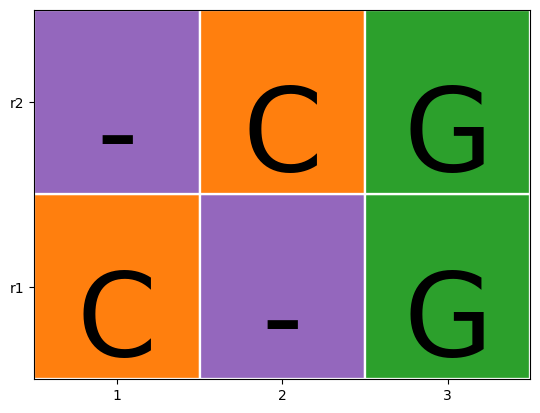

In [432]:
ax = plt.gca()
ax.set(xlim=[-20,20], ylim=[-20, 20])
ax, color_map=DrawMSA(msa=["AC-G-T", "A-CGT-"], seq_names = ["r1", "r2"],
           start = 1, end = 3, color_order="ACGT")

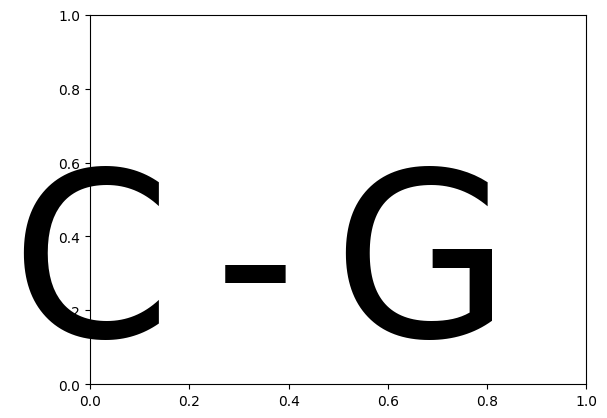

In [457]:
#ax = plt.gca()
#ax.set(xlim=[-20,20], ylim=[-20, 20])
DrawSeqLogo(["AC-G-T", "A-CGT-", "ACGAGT"], color_map, start = 1, end = 3)

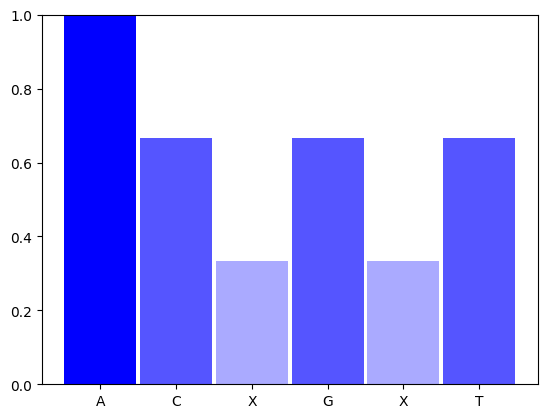

In [355]:
DrawConsensusHisto(msa=["AC-G-T", "A-CGT-", "ACGAGT"])

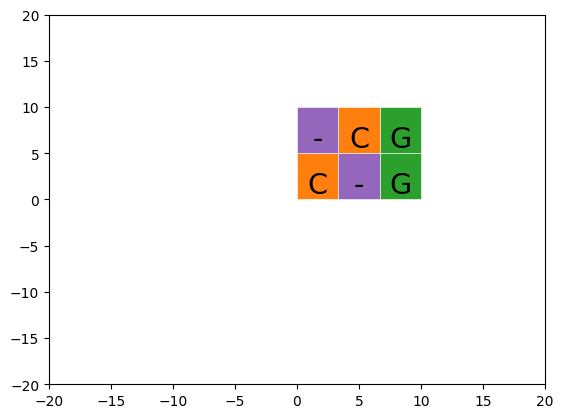

In [252]:
ax = plt.gca()
ax.set(xlim=[-20,20], ylim=[-20, 20])
ax=DrawMSA(msa=["AC-G-T", "A-CGT-"], color_order="ACGT-",
          axlim=[[0,10], [0,10]], start=1, end=3, ax=ax)